# ESN example with synthetic data. Classification task

In [25]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [26]:
from matplotlib import rcParams
COLOR = 'white'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

### 1. Generate synthetic data

In [27]:
data_dim = 1 # dimentionality of the data
num_samples = 500 # number of samples per class
num_classes = 3 # don't forget to change num_classes according to the number of classes in the dataset

In [28]:
# don't forget to change num_classes according to the number of classes in the dataset
np.random.seed(7)
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data = np.concatenate((x1, x2, x3), axis=1)[0]
data.shape

(1500,)

Text(0.5,1,'Generated synthetic data')

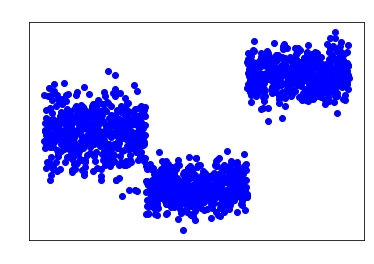

In [33]:
plot(data, 'bo')
title("Generated synthetic data")

In [6]:
# prepare labels
Yt = np.zeros(shape=(num_classes, num_classes * num_samples))
for i in range(num_classes):
    Yt[i, i * num_samples:(i + 1) * num_samples] = 1
Yt = np.transpose(Yt)

In [7]:
# # shuffle data
# np.random.shuffle(np.transpose(data))
# data.shape

In [8]:
# imshow(data, aspect='auto')
# title("Shuffled data")
# colorbar()

### 2. Prep reservoir

In [9]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 100
a = 0.3 # leaking rate
random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Computing spectral radius...
done.


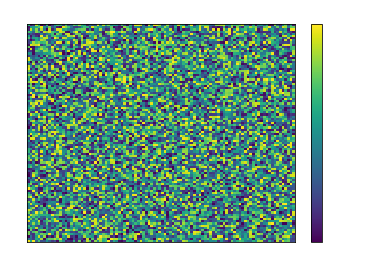

In [10]:
imshow(W, aspect='auto')
title("Reservoir adjacency matrix $\mathbf{W}$")
colorbar()

In [11]:
# allocated memory for the design (collected states) matrix
trainLen = num_samples * num_classes
initLen = 0 # since we will run the ESN in classification mode we don't need initializaiton
X = zeros((1+inSize+resSize,trainLen-initLen))

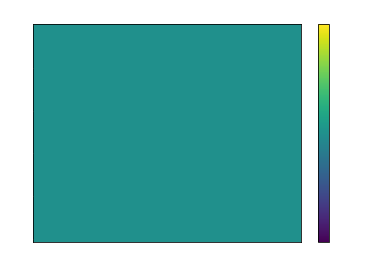

In [12]:
imshow(X, aspect='auto')
title("Initial activations (zero) $\mathbf{x}(n)$")
colorbar()

### 3. Record reservoir activations $\mathbf{x}(n)$

In [13]:
# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]

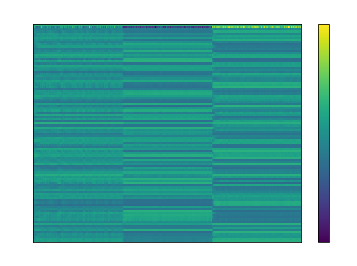

In [14]:
imshow(X, aspect='auto')
title("Reservoir activations $\mathbf{x}(n)$")
colorbar()

### 4. Train the readout $\mathbf{W}^{out}$

In [15]:
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt.T,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )

Text(0.5,1,'Output weights $\\mathbf{W}^{out}$')

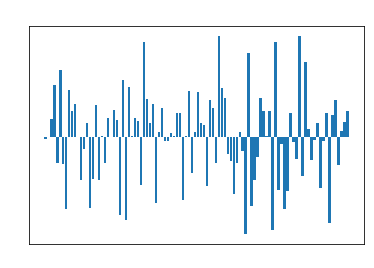

In [16]:
bar( range(1+inSize+resSize), [v[0] for v in Wout.T] )
title('Output weights $\mathbf{W}^{out}$')

### 5. Test

#### Generate test dataset

In [17]:
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data_test = np.concatenate((x1, x2, x3), axis=1)[0]
data_test.shape

(1500,)

#### Record reservoir activations for the test set

In [18]:
X_test = zeros((1+inSize+resSize,trainLen-initLen))

In [19]:
# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X_test[:,t-initLen] = vstack((1,u,x))[:,0]

#### Get results of testing. Compute MSE

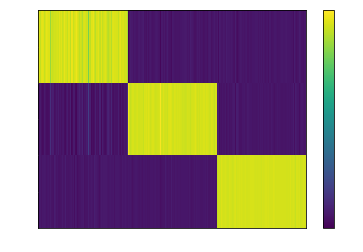

In [20]:
Y_res = dot(Wout, X_test)
imshow(Y_res, aspect='auto')
colorbar()

In [21]:
# compute MSE for the first errorLen time steps
errorLen = num_classes * num_samples
mse = sum( square( Yt.T - Y_res ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = 0.0024994573575389486
